In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "/users/youcefdjeddar/downloads/cars/"

In [4]:
files = os.listdir(f'{PATH}valid/ped')

In [5]:
img = plt.imread(f'{PATH}valid/ped/{files[5]}')

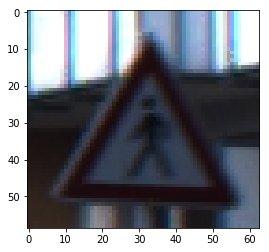

In [6]:
plt.imshow(img)

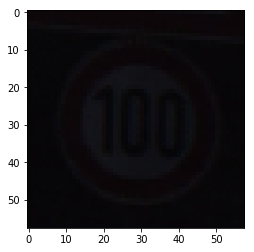

In [8]:
img = plt.imread(f'{PATH}valid/100/{files[5]}') ; plt.imshow(img)

I have selected deliberately tedious images.

In [144]:
files1 = os.listdir(f'{PATH}train/ped')

In [145]:
len(files1)

210

In [147]:
files2 = os.listdir(f'{PATH}train/noentry') ; len(files2)

311

In [30]:
img[:2,:2]

array([[[109, 169, 194],
        [200, 240, 255]],

       [[114, 174, 199],
        [193, 236, 255]]], dtype=uint8)

In [31]:
img.shape

(59, 63, 3)

The shape of an image is a 3d Tensor.

In [32]:
files1 = os.listdir(f'{PATH}valid/left')

In [133]:
img1 = plt.imread(f'{PATH}valid/left/{files1[95]}')

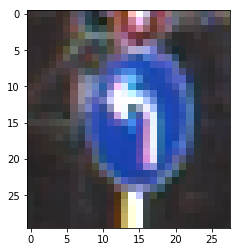

In [134]:
plt.imshow(img1)

In [35]:
sz = 224
arch=resnet50

I opted for an image size of 224 - comparable to ImageNet. I also chose ResNet50 as architecture.

In [36]:
data = ImageClassifierData.from_paths(PATH, tfms = tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data)

In [37]:
learn.fit(0.001, 3)

epoch      trn_loss   val_loss   accuracy                  
    0      1.525538   1.327263   0.548178  
    1      1.031104   1.198549   0.57247                   
    2      0.776795   1.149901   0.587045                  


[array([1.1499]), 0.5870445344129555]

Without any param tuning, the model got already a score of 70%. 

In [38]:
learn.lr_find()

 93%|█████████▎| 51/55 [09:02<00:41, 10.48s/it, loss=1.76] 

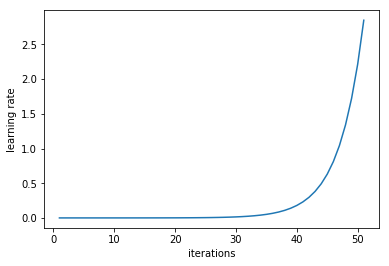

In [39]:
learn.sched.plot_lr()

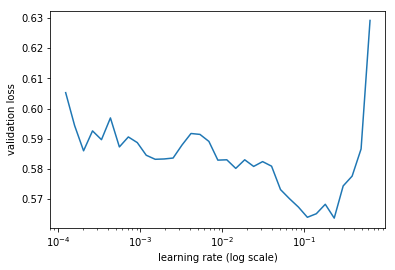

In [40]:
learn.sched.plot()

In [41]:
learn.fit(0.05, 3)

epoch      trn_loss   val_loss   accuracy                  
    0      0.545632   1.374603   0.603644  
    1      0.384198   1.485622   0.613765                  
    2      0.314756   1.505552   0.62753                   


[array([1.50555]), 0.6275303643724697]

In [21]:
data.classes

['100',
 '2-ways',
 '30',
 '50',
 'left',
 'noentry',
 'ped',
 'ped_crossing',
 'right']

In [136]:
y

array([0, 0, 0, ..., 8, 8, 8])

In [58]:
tfms = tfms_from_model(resnet34, 64, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms = tfms)

In [59]:
learn = ConvLearner.pretrained(arch, data)

In [60]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [61]:
ims = np.stack([get_augs() for i in range(9)])

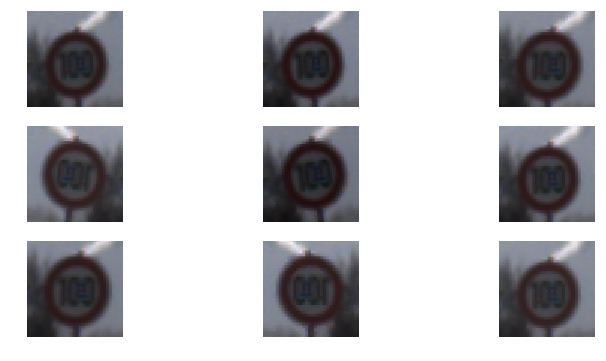

In [62]:
plots(ims, rows=3)

In [63]:
learn.lr_find()

 95%|█████████▍| 52/55 [00:59<00:03,  1.13s/it, loss=3.41]

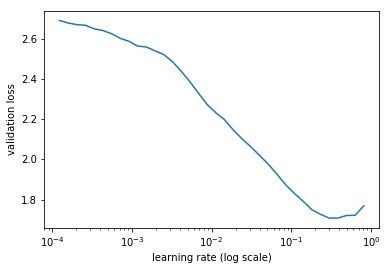

In [64]:
learn.sched.plot()

In [66]:
learn.fit(0.01, 5)

epoch      trn_loss   val_loss   accuracy                  
    0      0.356055   1.065258   0.645749  
    1      0.320791   1.004296   0.653846                  
    2      0.301048   1.020337   0.640891                  
    3      0.27757    1.046402   0.65749                   
    4      0.267788   1.161441   0.62915                   


[array([1.16144]), 0.6291497975708502]

In [67]:
learn.precompute = False

In [68]:
%time learn.fit(0.01, 5, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.234845   1.093622   0.644939  
    1      0.221791   1.105682   0.648583                  
    2      0.220632   1.126762   0.653036                  
    3      0.214441   1.082206   0.654251                  
    4      0.21268    1.11607    0.642105                  
CPU times: user 19min 30s, sys: 1min 14s, total: 20min 44s
Wall time: 10min 24s


[array([1.11607]), 0.6421052631578947]

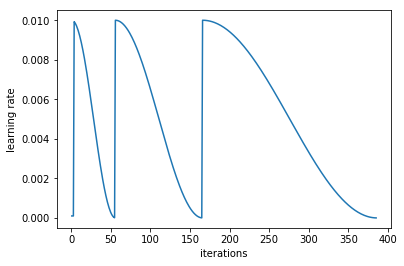

In [76]:
learn.sched.plot_lr()

Here I incorporated data augmentation. A technique that takes an image and flip it a little bit, rotate it a little bit...etc to generate new data.

In [70]:
lr = np.array([0.0001, 0.0003, 0.001])

In [71]:
learn.save('224_lastlayer')

In [112]:
learn.load('224_lastlayer')

In [113]:
learn.unfreeze()

In [114]:
lr=np.array([1e-4,1e-3,1e-2])

In [115]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.481624   0.835255   0.678543  
    1      0.271857   0.887933   0.704049                  
    2      0.171447   0.841962   0.709312                  
    3      0.141687   0.923316   0.695951                  
    4      0.120223   0.865118   0.722672                  
    5      0.103597   0.849063   0.74413                   
    6      0.092977   0.861023   0.732389                   


[array([0.86102]), 0.7323886639676114]

In [116]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [117]:
accuracy_np(probs, y)

0.7591093117408907

In [118]:
from sklearn.metrics import confusion_matrix

In [126]:
cm = confusion_matrix(y, preds)

In [127]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

[[417   0  35  48   0   0   0   0   0]
 [  0  45   0   0   3   0   0   0  12]
 [  1   0 463  96   0   0   0   0   0]
 [ 46   0 158 381   0   0   0   0   0]
 [  0  13   0   2 142   0   0   0  73]
 [  0   0   2   0   0 208   0   0   0]
 [  0   0   0   0   0   0  58  42   0]
 [  0   0   0   0   0   0  93   7   0]
 [  0   0   2   0  18   0   0   0 105]]


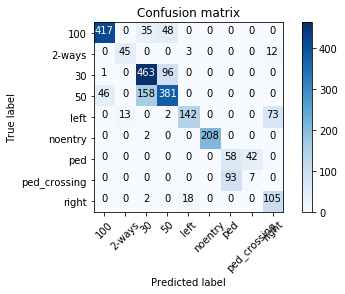

In [128]:
plot_confusion_matrix(cm, data.classes)